In [ ]:
!odsc conda install -s fspyspark32_p38_cpu_v2

Oracle Data Science service sample notebook.

Copyright (c) 2022, 2023 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Schema enforcement and schema evolution</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, data sources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift, and training serving skew all lead to increased model development time and poor model performance. Feature store can be used to solve many of the problems becuase it provides a centralised way to transform and access data for training and serving time. Feature store helps define a standardised pipeline for ingestion of data and querying of data. This notebook shows how schema enforcement and schema evolution are carried out in Feature Store

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/overview-roles.png"  />
</div>

## Contents:

- <a href='#introduction'>1. Introduction</a>
- <a href='#pre_requisites'>2. Pre-requisites to Running this Notebook</a>
    - <a href='#setup_setup'>2.1. Setup</a>
    - <a href='#policies_'>2.2. Policies</a>
    - <a href='#authentication'>2.3. Authentication</a>
    - <a href='#variables'>2.4. Variables</a>
- <a href='#schema'>3. Schema enforcement and schema evolution</a>
    - <a href='#dataexploration'>3.1. Exploration of data in feature store</a>
    - <a href='#feature_store'>3.2. Create feature store logical entities</a>
    - <a href='#schema_enforcement'>3.3. Schema enforcement</a>
    - <a href='#schema_evolution'>3.4. Schema evolution</a>
    - <a href='#ingestion_modes'>3.5. Ingestion Modes</a>
        - <a href='#append'>3.5.1. Append</a>
        - <a href='#overwrite'>3.5.2. Overwrite</a>
        - <a href='#upsert'>3.5.3. Upsert</a>
    - <a href='#history'>3.6. Viewing Feature Group History</a>
    - <a href='#preview'>3.7. Time travel Queries on Feature Group </a>
- <a href='#references'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id='introduction'></a>
# 1. Introduction

OCI Data Science feature store is a stack-based API solution that's deployed using OCI Resource Manager in your tenancy.

Review the following key terms to understand the Data Science feature store:


* **Feature Vector**: Set of feature values for any one primary or identifier key. For example, all or a subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Or, an entity is an object or concept that is described by its features. Examples of entities are customer, product, transaction, review, image, document, and so on.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in machine learning (ML) models. It serves as an organizational unit within the feature store for you to manage, version, and share features across different ML projects. By organizing features into groups, data scientists and ML engineers can efficiently discover, reuse, and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: A feature group job is the processing instance of a feature group. Each feature group job includes validation and statistics results.

* **Dataset**: A dataset is a collection of features that are used together to either train a model or perform model inference.

* **Dataset Job**: A dataset job is the processing instance of a dataset. Each dataset job includes validation and statistics results.

<a id='pre_requisites'></a>
# 2. Pre-requisites to Running this Notebook
Notebook Sessions are accessible using the PySpark 3.2 and Feature Store Python 3.8 (fspyspark32_p38_cpu_v2) conda environment.

You can customize `fspyspark32_p38_cpu_v2`, publish it, and use it as a runtime environment for a Notebook session.


<a id='setup_setup'></a>
### 2.1. Setup

<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='policies_'></a>
### 2.2. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="authentication"></a>
### 2.3. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook session.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"fs_service_endpoint": "https://{api_gateway}/20230101"})

<a id="variables"></a>
### 2.4. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and  `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = os.environ.get("NB_SESSION_COMPARTMENT_OCID")
metastore_id = "<metastore_id>"

<a id="schema"></a>
# 3. Schema enforcement and schema evolution
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html).Schema enforcement is a Delta Lake feature that prevents you from appending data with a different schema to a table.To change a table's current schema and to accommodate data that is changing over time,schema evolution feature is used while performing an append or overwrite operation.

In [3]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode

from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id='dataexploration'></a>
### 3.1. Exploration of data in feature store

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_store_demo.jpg" width="700" height="350" />
</div>

In [4]:
flights_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
flights_df = flights_df.head(100)
flights_df.head()

  flights_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,1,1,4,AS,98,ANC,SEA
1,2015,1,1,4,AA,2336,LAX,PBI
2,2015,1,1,4,US,840,SFO,CLT
3,2015,1,1,4,AA,258,LAX,MIA
4,2015,1,1,4,AS,135,SEA,ANC


In [5]:
columns = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE']
airports_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airports.csv")[columns]
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,31.53552,-84.19447


In [6]:
airlines_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


<a id="feature_store"></a>
### 3.2. Create feature store logical entities

#### 3.2.1. Feature Store
Feature store is the top level entity for feature store service

In [7]:
feature_store_resource = (
    FeatureStore().
    with_description("Data consisting of flights").
    with_compartment_id(compartment_id).
    with_display_name("flights details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [8]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Data consisting of flights
  displayName: flights details
  id: 147791C6CF90DDEC594A53655BA8EDA6
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxya2ipeqjr2m7npnn3kboq4s27erl3ts56wggl6ls6gpn3q
type: featureStore

#### 3.2.2. Entity
An entity is a group of semantically related features.

In [9]:
entity = feature_store.create_entity(
    display_name="Flight details schema evolution/enforcement",
    description="description for flight details"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: description for flight details
  featureStoreId: 147791C6CF90DDEC594A53655BA8EDA6
  id: 32E8CCEC72BD73F665B0B6180CB2100A
  name: Flight details schema evolution/enforcement
type: entity

<a id="create_feature_group_airport"></a>
#### 3.2.3. Feature Group

Create feature group for airport

In [10]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

expectation_suite_airports = ExpectationSuite(
    expectation_suite_name="test_airports_df"
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "IATA_CODE"},
    )
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "LATITUDE", "min_value": -1.0, "max_value": 1.0},
    )
)

expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "LONGITUDE", "min_value": -1.0, "max_value": 1.0},
    )
)

{"expectation_type": "expect_column_values_to_be_between", "kwargs": {"column": "LONGITUDE", "min_value": -1.0, "max_value": 1.0}, "meta": {}}

In [11]:
feature_group_airports = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airport_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airports_df)
    .with_expectation_suite(
        expectation_suite=expectation_suite_airports,
        expectation_type=ExpectationType.LENIENT,
     )
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/12/11 07:54:41 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]



In [12]:
feature_group_airports.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 32E8CCEC72BD73F665B0B6180CB2100A
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 147791C6CF90DDEC594A53655BA8EDA6
  id: ED84DFFD7CF86AAA612CAFD01DA9EBAA
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

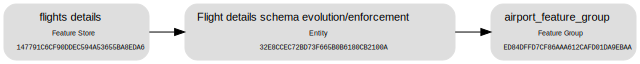

In [13]:
feature_group_airports.show()

In [14]:
feature_group_airports.materialise(airports_df)

Hive Session ID = d2e52dd8-8573-42c6-bd04-d83dcd66bc48


INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

  logger.warn("Reference profile is empty")



INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ ED84DFFD7CF86AAA612CAFD01DA9EBAA │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="schema_enforcement"></a>
### 3.3. Schema enforcement

Schema enforcement, also known as schema validation, is a safeguard in Delta Lake that ensures data quality by rejecting writes to a table that do not match the table's schema. For example, a front desk manager at a busy restaurant that only accepts reservations, the schema enforcement checks to see whether each column in the data inserted into the table is in the list of expected columns. Meaning each one has a "reservation", and rejects any writes with columns that aren't on the list.

In [15]:
columns = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE', 'COUNTRY']
airports_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airports.csv")[columns]
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,LATITUDE,LONGITUDE,COUNTRY
0,ABE,Lehigh Valley International Airport,Allentown,PA,40.65236,-75.44040,USA
1,ABI,Abilene Regional Airport,Abilene,TX,32.41132,-99.68190,USA
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,35.04022,-106.60919,USA
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,45.44906,-98.42183,USA
4,ABY,Southwest Georgia Regional Airport,Albany,GA,31.53552,-84.19447,USA


In [16]:
feature_group_airports.with_schema_details_from_dataframe(airports_df)
feature_group_airports.update()

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]




kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 32E8CCEC72BD73F665B0B6180CB2100A
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 147791C6CF90DDEC594A53655BA8EDA6
  id: ED84DFFD7CF86AAA612CAFD01DA9EBAA
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

In [17]:
feature_group_airports.materialise(airports_df)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

<a id="schema_evolution"></a>
### 3.4. Schema evolution

Schema evolution allows you to change a table's current schema to accommodate data that is changing over time. Typically, it's used when performing an append or overwrite operation to automatically adapt the schema to include one or more new columns.

In [18]:
from ads.feature_store.feature_option_details import FeatureOptionDetails
feature_option_details = FeatureOptionDetails().with_feature_option_write_config_details(merge_schema=True)

In [19]:
feature_group_airports.materialise(
    input_dataframe=airports_df,
    feature_option_details=feature_option_details
)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

  logger.warn("Reference profile is empty")

INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ ED84DFFD7CF86AAA612CAFD01DA9EBAA │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


In [20]:
feature_group_airports


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 32E8CCEC72BD73F665B0B6180CB2100A
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 147791C6CF90DDEC594A53655BA8EDA6
  id: ED84DFFD7CF86AAA612CAFD01DA9EBAA
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

<a id="ingestion_modes"></a>
### 3.5. Ingestion modes

<a id="append"></a>
#### 3.5.1. Append

In ``append`` mode, new data is added to the existing table. If the table already exists, the new data is appended to it, extending the dataset. This mode is suitable for scenarios where you want to continuously add new records without modifying or deleting existing data. It preserves the existing data and only appends the new data to the end of the table.

In [22]:
from ads.feature_store.feature_group_job import BatchIngestionMode
feature_group_airports.materialise(airports_df, ingestion_mode=BatchIngestionMode.APPEND)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

  logger.warn("Reference profile is empty")

INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ ED84DFFD7CF86AAA612CAFD01DA9EBAA │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="overwrite"></a>
#### 3.5.2. Overwrite
In ``overwrite`` mode, the existing table is replaced entirely with the new data being saved. If the table already exists, it is dropped and a new table is created with the new data. This mode is useful when you want to completely refresh the data in the table with the latest data and discard all previous records.

In [23]:
from ads.feature_store.feature_group_job import BatchIngestionMode
feature_group_airports.materialise(airports_df, ingestion_mode=BatchIngestionMode.OVERWRITE)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

  logger.warn("Reference profile is empty")

INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ ED84DFFD7CF86AAA612CAFD01DA9EBAA │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="upsert"></a>
#### 3.5.3. Upsert
``Upsert`` mode (merge mode) is used to update existing records in the table based on a primary key or a specified condition. If a record with the same key exists, it is updated with the new data. Otherwise, a new record is inserted. This mode is useful for maintaining and synchronizing data between the source and destination tables while avoiding duplicates.

In [24]:
from ads.feature_store.feature_group_job import BatchIngestionMode
feature_group_airports.materialise(airports_df, ingestion_mode=BatchIngestionMode.UPSERT)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

<a id="history"></a>
### 3.6. Viewing Feature Group History
You can call the ``history()`` method of the FeatureGroup instance to show history of the feature group.

In [25]:
feature_group_airports.history().toPandas()

  if LooseVersion(pa.__version__) < LooseVersion("2.0.0"):

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):



,version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
0,3,2023-12-11 07:57:00,None,None,CREATE OR REPLACE TABLE AS SELECT,"{'isManaged': 'true', 'description': None, 'partitionBy': '[]', 'properties': '{}'}",None,None,None,2.0,Serializable,False,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20732'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
1,2,2023-12-11 07:56:39,None,None,WRITE,"{'mode': 'Append', 'partitionBy': '[]'}",None,None,None,1.0,Serializable,True,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20732'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
2,1,2023-12-11 07:55:54,None,None,CREATE OR REPLACE TABLE AS SELECT,"{'isManaged': 'true', 'description': None, 'partitionBy': '[]', 'properties': '{}'}",None,None,None,0.0,Serializable,False,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20732'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1
3,0,2023-12-11 07:55:17,None,None,CREATE OR REPLACE TABLE AS SELECT,"{'isManaged': 'true', 'description': None, 'partitionBy': '[]', 'properties': '{}'}",None,None,None,NaN,Serializable,False,"{'numFiles': '2', 'numOutputRows': '322', 'numOutputBytes': '20174'}",None,Apache-Spark/3.2.1 Delta-Lake/2.0.1


<a id="preview"></a>
### 3.7. Time travel Queries on Feature Group

You can call the ``as_of()`` method of the FeatureGroup instance to get specified point in time and time traveled data.
The ``.as_of()`` method takes the following optional parameter:

- commit_timestamp: date-time. Commit timestamp for feature group
- version_number: int. Version number for feature group

In [26]:
feature_group_airports.as_of(version_number = 0).show()

+---------+--------------------+-------------+-----+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+--------+----------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|      Abilene|   TX|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|45.44906| -98.42183|
|      ABY|Southwest Georgia...|       Albany|   GA|31.53552| -84.19447|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|41.25305| -70.06018|
|      ACT|Waco Regional Air...|         Waco|   TX|31.61129| -97.23052|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|40.97812|-124.10862|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|39.45758| -74.57717|
|      ADK|        Adak Airport|         Adak|   AK|51.87796|-176.64603|
|      ADQ|      Kodiak Airport|       Kodiak|   AK

In [27]:
feature_group_airports.as_of(version_number = 1).show()

+---------+--------------------+-------------+-----+--------+----------+-------+
|IATA_CODE|             AIRPORT|         CITY|STATE|LATITUDE| LONGITUDE|COUNTRY|
+---------+--------------------+-------------+-----+--------+----------+-------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|40.65236|  -75.4404|    USA|
|      ABI|Abilene Regional ...|      Abilene|   TX|32.41132|  -99.6819|    USA|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|35.04022|-106.60919|    USA|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|45.44906| -98.42183|    USA|
|      ABY|Southwest Georgia...|       Albany|   GA|31.53552| -84.19447|    USA|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|41.25305| -70.06018|    USA|
|      ACT|Waco Regional Air...|         Waco|   TX|31.61129| -97.23052|    USA|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|40.97812|-124.10862|    USA|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|39.45758| -74.57717|    USA|
|      ADK|        Adak Airp

<a id='references'></a>
# 4. References
- [Feature Store Documentation](https://feature-store-accelerated-data-science.readthedocs.io/en/latest/overview.html)
- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)